# Variational Autoencoders (VAE)
Refer to paper - Auto-Encoding Variational Bayes

In [1]:
import torch
import matplotlib.pyplot as plt
# import torch.nn as nn
from torch import nn # Better way
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
device = torch.device('mps')
device

device(type='mps')

In [3]:
INPUT_DIM = 28*28
HIDDEN_DIM = 300
Z_DIM = 20
NUM_EPOCHS = 10
BATCH_SIZE = 1024
LR = 3e-4

In [4]:
train_data = MNIST(
    root = '../datasets',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

In [5]:
train_loader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [6]:
class VariationalAutoEncoder(nn.Module):
    """
        Parameters
        ----------
        input_dim: Input dimension
        hidden_dim: Hidden dimension/nodes
        z_dim: Bottleneck dimension (z is the term used in the paper)

        Other terms
        ----------
        mu: Mean vector
        sigma: Variance vector (Assuming covariance matrix is DIAGONAL - taking 
        only the diagonal terms and creating a vector)
    """
    def __init__(self, input_dim = 28*28, hidden_dim = 300, z_dim = 20) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # Encoder
        self.img2hid = nn.Linear(input_dim, hidden_dim).to(device=device)
        self.hid2mu = nn.Linear(hidden_dim, z_dim).to(device=device)
        self.hid2sigma = nn.Linear(hidden_dim, z_dim).to(device=device)

        # Decoder
        self.z2hidden = nn.Linear(z_dim, hidden_dim).to(device=device)
        self.hid2img = nn.Linear(hidden_dim, input_dim).to(device=device)
    
    def encoder(self, x):
        # q_phi(z|x)
        h = torch.relu(self.img2hid(x.to(device=device))).to(device=device)
        mu, sigma = self.hid2mu(h), torch.relu(self.hid2sigma(h)) # Since sigma >  0, but mu can take any value in R^d
        return mu.to(device=device), sigma.to(device=device)

    def decoder(self, z):
        # p_theta(x|z)
        return torch.sigmoid(self.hid2img(torch.relu(self.z2hidden(z))))

    def forward(self, x):
        mu, sigma = self.encoder(x)
        epsilon = torch.randn_like(sigma).to(device=device)
        z_reparameterized = mu + sigma * epsilon
        x_reconstructed = self.decoder(z_reparameterized)
        return x_reconstructed, mu, sigma # mu, sigma for KL divergence loss, x_reconstructed for reconstruction loss

In [7]:
# Checking dimension correctness
x = torch.randn(4, 28*28).to(device=device) # (batch_size, input_dim)
vae = VariationalAutoEncoder(input_dim = 28*28, hidden_dim = 300, z_dim = 20)
x_reconstructed, mu, sigma = vae(x)
print(x_reconstructed.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


In [8]:
vae = VariationalAutoEncoder(INPUT_DIM, HIDDEN_DIM, Z_DIM).to(device)

In [9]:
criterion = nn.BCELoss(reduction="sum") # 3 options of reduction - "none" (no reduction), "mean" (default), "sum"
optimizer = torch.optim.Adam(vae.parameters(), lr = LR)

In [10]:
for epoch in range(NUM_EPOCHS): 
    loop_loader = tqdm(enumerate(train_loader))
    print(f'Epoch {epoch}')
    for i, (x, _) in loop_loader:
        # Forward pass
        x = x.to(device).view(x.shape[0], INPUT_DIM) # view is better the reshape as it does not make a copy
        x_reconstructed, mu, sigma = vae(x)

        # Loss
        reconstruction_loss = criterion(x_reconstructed, x)
        # The regularizer as in the paper
        # Needed to maximize in the paper, hence minimizing its negative
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = reconstruction_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop_loader.set_postfix(loss = loss.item())
    print('Loss =',loss.item())

1it [00:00,  5.64it/s, loss=inf]

Epoch 0


59it [00:02, 25.34it/s, loss=1.7e+5] 


Loss = 170486.328125


3it [00:00, 26.65it/s, loss=2.77e+5]

Epoch 1


59it [00:02, 27.49it/s, loss=1.46e+5]


Loss = 145617.25


3it [00:00, 26.73it/s, loss=2.44e+5]

Epoch 2


59it [00:02, 27.49it/s, loss=1.36e+5]


Loss = 135833.671875


3it [00:00, 26.66it/s, loss=2.29e+5]

Epoch 3


59it [00:02, 26.86it/s, loss=1.32e+5]


Loss = 131534.03125


3it [00:00, 26.85it/s, loss=2.22e+5]

Epoch 4


59it [00:02, 27.67it/s, loss=1.27e+5]


Loss = 126984.4296875


3it [00:00, 26.13it/s, loss=2.15e+5]

Epoch 5


59it [00:02, 27.53it/s, loss=1.23e+5]


Loss = 123480.109375


3it [00:00, 26.78it/s, loss=2.07e+5]

Epoch 6


59it [00:02, 27.44it/s, loss=1.2e+5] 


Loss = 119503.015625


3it [00:00, 25.57it/s, loss=2.01e+5]

Epoch 7


30it [00:01, 25.97it/s, loss=1.97e+5]

In [22]:
def inference(digit, num_examples = 1):
    """
        Generates (num_examples) of a particular digit.
        Specifically, we can extract an example of each digit,
        then after we have the mu, sigma representation for
        each digit, we can sample from that
    """
    images = [] # Getting one image for every number
    idx = 0
    for image, label in train_data:
        if label == idx:
            images.append(image)
            idx+=1
        if idx == 10:
            break

    encodings_digit = []
    for num in range(10):
        with torch.no_grad():
            mu, sigma = vae.encoder(images[num].to(device).view(-1,28*28))
        encodings_digit.append((mu, sigma)) # Obtaining mu and sigma for every digit
    
    mu_final, sigma_final = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma_final)
        z = mu_final + sigma_final*epsilon
        output = vae.decoder(z).view(-1,28,28)
        plt.figure(example+1)
        plt.imshow(output.cpu().detach().numpy().transpose(1,2,0), cmap='gray')

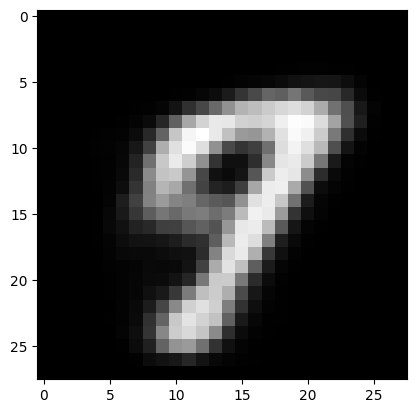

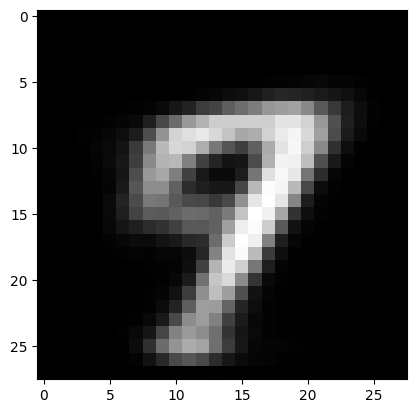

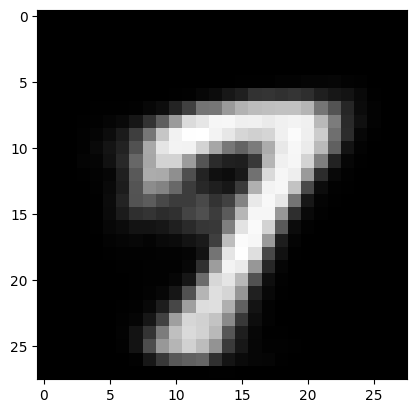

In [23]:
inference(7, num_examples=3)